# MS025 Preprocess
Created: 01/29/2024 \
Updated: 09/13/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
from ast import literal_eval



import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/LFPAnalysis/')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [5]:
# Specify root directory for un-archived data and results 
base_dir = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'

subj_id = 'MS025'
subj_format = ['nlx']
subj_site = ['MSSM']


In [6]:
#### print date of last run
date = datetime.date.today().strftime('%m%d%Y')
print(date)

09142024


# Make mne_data


### Load and resample data


In [7]:
load_path = f'{neural_dir}{subj_id}/raw_nlx/'
seeg_names = None
resp_names = None
ekg_names = None
eeg_names = None

In [8]:
### removing extraneous numbering from channel names 

# per Shawn, MSSM data seems to sometime have a "_0000.ncs" to "_9999.ncs" appended to the end of real data
pattern = re.compile(r"_\d{4}\.ncs")  # regex pattern to match "_0000.ncs" to "_9999.ncs"
ncs_files = [x for x in glob(f'{load_path}/*.ncs') if re.search(pattern, x)]
# just in case this changes in the future: 
if len(ncs_files) == 0: 
    ncs_files = glob(f'{load_path}/*.ncs')
    if not seeg_names:
        seeg_names = [x.split('/')[-1].replace('.ncs','') for x in glob(f'{load_path}/[R,L]*.ncs')]
else:
    if not seeg_names:
        seeg_names = [x.split('/')[-1].replace('.ncs','').split('_')[0] for x in glob(f'{load_path}/[R,L]*.ncs') if re.search(pattern, x)]

In [9]:
seeg_names = [x.lower() for x in seeg_names] 
seeg_names

['rhplt4',
 'lptpt4',
 'lcmip1',
 'racas12',
 'rpvnh10',
 'lpvnh9',
 'rcmip14',
 'raglt7',
 'lhplt7',
 'lptpt8',
 'lacas2',
 'laglt1',
 'lpvnh2',
 'laglt2',
 'lmolf1',
 'lacas10',
 'lcmip14',
 'lacas9',
 'lacas3',
 'racas3',
 'lcmip11',
 'rcmip3',
 'rhplt2',
 'lacas8',
 'lmolf5',
 'lcmip6',
 'racas7',
 'lptpt1',
 'lhplt11',
 'lhplt5',
 'rcmip4',
 'lcmip9',
 'lmolf9',
 'rhplt9',
 'lptpt2',
 'lmolf8',
 'rpvnh1',
 'lpvnh13',
 'lpvnh12',
 'rmolf5',
 'lmcms4',
 'lpvnh14',
 'racas9',
 'racas5',
 'raglt5',
 'lmolf6',
 'rcmip11',
 'rmcms9',
 'lmcms10',
 'lmcms2',
 'rpvnh4',
 'lptpt9',
 'racas2',
 'rcmip7',
 'rhplt7',
 'racas1',
 'lmcms5',
 'lacas12',
 'lmcms9',
 'laglt5',
 'raglt4',
 'lacas4',
 'rcmip13',
 'rmolf3',
 'rcmip5',
 'raglt1',
 'rmcms5',
 'rhplt1',
 'lpvnh10',
 'raglt8',
 'rhplt6',
 'rmolf2',
 'lcmip7',
 'lcmip8',
 'lhplt6',
 'racas4',
 'lacas11',
 'lpvnh3',
 'lmcms3',
 'rmolf4',
 'rhplt10',
 'rpvnh6',
 'rcmip8',
 'raglt9',
 'laglt3',
 'lacas7',
 'rmcms2',
 'rpvnh8',
 'rpvnh3',
 'la

In [10]:
### empty vecs to load data into 

signals = [] #data
srs = [] #sampling rate
ch_name = [] #channel name
ch_type = [] #channel type (seeg, eeg etc.)

In [11]:
ncs_files.sort() ### added to make channels in alphabetical order 

In [12]:
ncs_files

['/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS025/raw_nlx/LAglT1_0012.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS025/raw_nlx/LAglT2_0012.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS025/raw_nlx/LAglT3_0012.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS025/raw_nlx/LAglT4_0012.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS025/raw_nlx/LAglT5_0012.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS025/raw_nlx/LAglT6_0012.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS025/raw_nlx/LAglT7_0012.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS025/raw_nlx/LAglT8_0012.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS025/raw_nlx/LAglT9_0012.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS025/raw_nlx/LCMiP10_0012.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS025/raw_nlx/LCMiP11_0012.ncs',
 '/sc/arion/projects/guLab/Ali

In [13]:
for chan_path in ncs_files:
    chan_name = chan_path.split('/')[-1].replace('.ncs','')
    # strip the file type off the end if needed 
    if '_' in chan_name:
        chan_name = chan_name.split('_')[0]
    try:
        fdata = nlx_utils.load_ncs(chan_path)
    except IndexError: 
        print(f'No data in channel {chan_name}')
        continue
    if eeg_names:
        if chan_name.lower() in eeg_names:
            ch_type.append('eeg')
    if resp_names:
        if chan_name.lower() in resp_names:
            ch_type.append('bio')
    if ekg_names:
        if chan_name.lower() in ekg_names: 
            ch_type.append('ecg') 
    if seeg_names: 
        if chan_name.lower() in seeg_names:
            ch_type.append('seeg')  
        elif chan_name.lower()[0] == 'u':
            # microwire data
            ch_type.append('seeg')  
    signals.append(fdata['data'])
    srs.append(fdata['sampling_rate'])
    ch_name.append(chan_name)
    if len(ch_type) < len(ch_name):
        ch_type.append('misc')
        print(f'Unidentified data type in {chan_name}') #this output should tell you what your photodiode name is

Unidentified data type in Photodiode


In [14]:
ch_name

['LAglT1',
 'LAglT2',
 'LAglT3',
 'LAglT4',
 'LAglT5',
 'LAglT6',
 'LAglT7',
 'LAglT8',
 'LAglT9',
 'LCMiP10',
 'LCMiP11',
 'LCMiP12',
 'LCMiP13',
 'LCMiP14',
 'LCMiP1',
 'LCMiP2',
 'LCMiP3',
 'LCMiP4',
 'LCMiP5',
 'LCMiP6',
 'LCMiP7',
 'LCMiP8',
 'LCMiP9',
 'LHplT10',
 'LHplT11',
 'LHplT12',
 'LHplT1',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LHplT5',
 'LHplT6',
 'LHplT7',
 'LHplT8',
 'LHplT9',
 'LPVNH10',
 'LPVNH11',
 'LPVNH12',
 'LPVNH13',
 'LPVNH14',
 'LPVNH1',
 'LPVNH2',
 'LPVNH3',
 'LPVNH4',
 'LPVNH5',
 'LPVNH6',
 'LPVNH7',
 'LPVNH8',
 'LPVNH9',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LaCaS1',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LmCmS10',
 'LmCmS11',
 'LmCmS12',
 'LmCmS1',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'LpTpT10',
 'LpTpT1',
 'LpTpT2',
 'LpTpT3',
 'LpTpT4',
 'LpTpT5',
 'LpTpT6',
 

In [15]:
srs

[2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,

In [16]:
target_sr = 500 #downsampling to 500 to be consistent with other data - alternative = np.min(srs)
mne_data_resampled = []

In [17]:
### resampling to 500Hz

for sr in np.unique(srs):
    ch_ix = np.where(srs==sr)[0].astype(int)
    info = mne.create_info([x for ix, x in enumerate(ch_name) if ix in ch_ix], sr, [x for ix, x in enumerate(ch_type) if ix in ch_ix])
    mne_data_temp = mne.io.RawArray([x for ix, x in enumerate(signals) if ix in ch_ix], info)
    if sr != target_sr:
        # resample down to one sample rate 
        mne_data_temp.resample(sfreq=target_sr, npad='auto', n_jobs=-1)
        mne_data_resampled.append(mne_data_temp)
    else: 
        mne_data = mne_data_temp
        

Creating RawArray with float64 data, n_channels=169, n_times=5078016
    Range : 0 ... 5078015 =      0.000 ...  2539.008 secs
Ready.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:  2.4min finished


In [19]:
### make sure timing is aligned post resampling --- check this 

#Because of the resampling, the end timings might not match perfectly:https://github.com/mne-tools/mne-python/issues/8257

if mne_data_resampled[0].tmax > mne_data_temp.tmax:
    mne_data_resampled[0].crop(tmin=0, tmax=mne_data_temp.tmax)
elif mne_data_resampled[0].tmax < mne_data_temp.tmax:
    mne_data_temp.crop(tmin=0, tmax=mne_data_resampled[0].tmax)
    

In [20]:
mne_data_resampled[0]

<RawArray | 169 x 1269504 (2539.0 s), ~1.60 GB, data loaded>

In [21]:
mne_data = mne_data_resampled[0]  #mne_data.add_channels([mne_data_temp]) to add more channels input mne object as list
# mne_data.add_channels([mne_data_resampled[1]])
mne_data

<RawArray | 169 x 1269504 (2539.0 s), ~1.60 GB, data loaded>

In [22]:
mne_data

<RawArray | 169 x 1269504 (2539.0 s), ~1.60 GB, data loaded>

In [21]:
# mne_data.ch_names

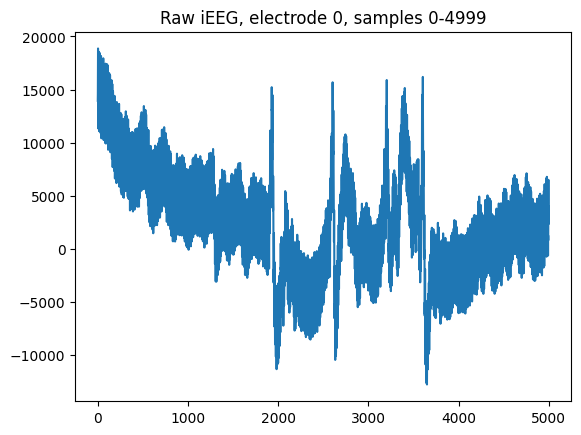

In [23]:
# Sanity check one channel data

plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Notch filter line noise

In [24]:
mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 168 out of 168 | elapsed:    7.6s finished


<RawArray | 169 x 1269504 (2539.0 s), ~1.60 GB, data loaded>

### Photodiode
- examine photodiode 

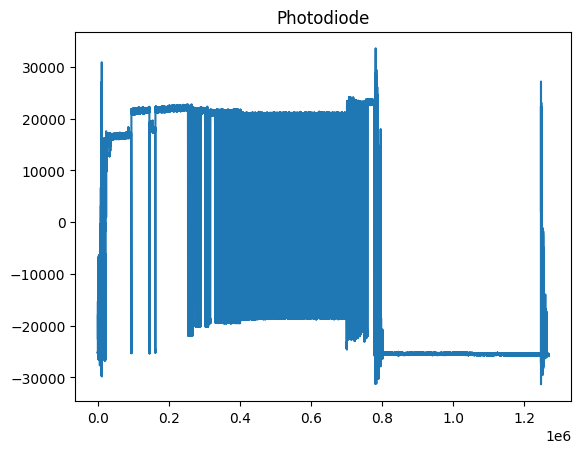

In [25]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("Photodiode")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

In [26]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode.fif', picks='Photodiode', overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS025/photodiode.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS025/photodiode.fif
[done]


In [27]:
mne_data.drop_channels(['Photodiode'])

<RawArray | 168 x 1269504 (2539.0 s), ~1.59 GB, data loaded>

### Anatomical Localization

In [28]:
### Rename channels to be lowercase before anatomical localization
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict)

<RawArray | 168 x 1269504 (2539.0 s), ~1.59 GB, data loaded>

In [29]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination,notes
0,LaCaS1,A32sg_L,-8.551953,47.560752,20.574440,-7.364096,42.879442,7.816402,Gray,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus F,NaN,NaN
1,LaCaS10,Unknown,-17.348071,64.346899,55.331263,-15.943065,67.827566,42.142829,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,OOB,NaN
2,LaCaS11,Unknown,-17.747895,65.545910,58.127789,-16.252304,69.749974,44.950649,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,OOB,NaN
3,LaCaS12,Unknown,-17.747895,65.945580,59.725803,-16.193126,70.554453,46.641912,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,OOB,NaN
4,LaCaS2,A32p_L,-9.751424,49.559103,24.968981,-8.600387,46.074869,12.332196,Gray,Left MSFG superior frontal gyrus medial segment,Unknown,L ACC,L CG,Left frontal pole 4 A,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,RPVNH9,mOccG_R,29.431284,-69.942282,-4.993797,29.084658,-86.459783,9.976051,White,Right Cerebral White Matter,Area hOc4lp,R Middle Occipital Gyrus,R LOcC,Right superior middle occipital gyrus D,NaN,NaN
168,uLAglT,rHipp_L,-16.148600,10.391424,-14.981390,-16.594453,-3.626931,-23.761121,Gray,Left Amygdala,Amygdala (LB),L ParaHippocampal Gyrus,L Hipp,Left parahippocampal gyrus A,Left amygdala inferior,NaN
169,uLmOlF,A11m_L,-8.951776,61.549208,-4.594294,-7.639574,50.840300,-25.038950,Gray,Left MOrG medial orbital gyrus,Area Fo1,L Superior Orbital Gyrus,L OrG,Left frontal orbital 2 B,NaN,NaN
170,uRAglT,rHipp_R,15.037636,10.391424,-14.182383,17.162481,-3.723941,-23.243948,Gray,Right Amygdala,Amygdala (LB),R ParaHippocampal Gyrus,R Hipp,Right amygdala inferior,NaN,NaN


In [30]:
list(elec_locs.label)

['LaCaS1',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LAglT1',
 'LAglT2',
 'LAglT3',
 'LAglT4',
 'LAglT5',
 'LAglT6',
 'LAglT7',
 'LAglT8',
 'LAglT9',
 'LCMiP1',
 'LCMiP10',
 'LCMiP11',
 'LCMiP12',
 'LCMiP13',
 'LCMiP14',
 'LCMiP2',
 'LCMiP3',
 'LCMiP4',
 'LCMiP5',
 'LCMiP6',
 'LCMiP7',
 'LCMiP8',
 'LCMiP9',
 'LHplT1',
 'LHplT10',
 'LHplT11',
 'LHplT12',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LHplT5',
 'LHplT6',
 'LHplT7',
 'LHplT8',
 'LHplT9',
 'LmCmS1',
 'LmCmS10',
 'LmCmS11',
 'LmCmS12',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'LmTpT1',
 'LmTpT10',
 'LmTpT2',
 'LmTpT3',
 'LmTpT4',
 'LmTpT5',
 'LmTpT6',
 'LmTpT7',
 'LmTpT8',
 'LmTpT9',
 'LPVNH1',
 'LPVNH10',
 'LPVNH11',
 'LPVNH12',
 'LPVNH13',
 'LPVNH14',
 'LPVNH2',
 'LPVNH3',
 'LPVNH4',
 'LPVNH5',
 'LPVNH6',
 

In [31]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['lptpt10', 'lptpt1', 'lptpt2', 'lptpt3', 'lptpt4', 'lptpt5', 'lptpt6', 'lptpt7', 'lptpt8', 'lptpt9']


In [32]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


Number of electrodes in the mne file is less than the number of electrodes in the localization file


In [33]:
unmatched_seeg #make sure there are no unmatched names


[]

In [34]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [35]:
new_name_dict #make sure this passes the eye test 


{'laglt1': 'laglt1',
 'laglt2': 'laglt2',
 'laglt3': 'laglt3',
 'laglt4': 'laglt4',
 'laglt5': 'laglt5',
 'laglt6': 'laglt6',
 'laglt7': 'laglt7',
 'laglt8': 'laglt8',
 'laglt9': 'laglt9',
 'lcmip10': 'lcmip10',
 'lcmip11': 'lcmip11',
 'lcmip12': 'lcmip12',
 'lcmip13': 'lcmip13',
 'lcmip14': 'lcmip14',
 'lcmip1': 'lcmip1',
 'lcmip2': 'lcmip2',
 'lcmip3': 'lcmip3',
 'lcmip4': 'lcmip4',
 'lcmip5': 'lcmip5',
 'lcmip6': 'lcmip6',
 'lcmip7': 'lcmip7',
 'lcmip8': 'lcmip8',
 'lcmip9': 'lcmip9',
 'lhplt10': 'lhplt10',
 'lhplt11': 'lhplt11',
 'lhplt12': 'lhplt12',
 'lhplt1': 'lhplt1',
 'lhplt2': 'lhplt2',
 'lhplt3': 'lhplt3',
 'lhplt4': 'lhplt4',
 'lhplt5': 'lhplt5',
 'lhplt6': 'lhplt6',
 'lhplt7': 'lhplt7',
 'lhplt8': 'lhplt8',
 'lhplt9': 'lhplt9',
 'lpvnh10': 'lpvnh10',
 'lpvnh11': 'lpvnh11',
 'lpvnh12': 'lpvnh12',
 'lpvnh13': 'lpvnh13',
 'lpvnh14': 'lpvnh14',
 'lpvnh1': 'lpvnh1',
 'lpvnh2': 'lpvnh2',
 'lpvnh3': 'lpvnh3',
 'lpvnh4': 'lpvnh4',
 'lpvnh5': 'lpvnh5',
 'lpvnh6': 'lpvnh6',
 'lpvnh7

In [36]:
# Rename the mne data according to the localization data

mne_data.rename_channels(new_name_dict)

<RawArray | 168 x 1269504 (2539.0 s), ~1.59 GB, data loaded>

In [37]:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of {len(left_seeg_names)} left sEEG and {len(right_seeg_names)} right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')



We have a total of 92 left sEEG and 76 right sEEG electrodes
We have a total of 168 sEEG electrodes


In [38]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
mne_data.set_channel_types(sEEG_mapping_dict)


<RawArray | 168 x 1269504 (2539.0 s), ~1.59 GB, data loaded>

In [39]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs 

<RawArray | 168 x 1269504 (2539.0 s), ~1.59 GB, data loaded>

In [40]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawArray | 168 x 1269504 (2539.0 s), ~1.59 GB, data loaded>

In [41]:
#this is just for my own personal info and to select how many channels to visualize at a time
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)
# probe_names

In [42]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [43]:
probe_ch_counts

{'lacas': 12,
 'laglt': 9,
 'lcmip': 14,
 'lhplt': 12,
 'lmcms': 12,
 'lmolf': 9,
 'lmtpt': 10,
 'lpvnh': 14,
 'racas': 12,
 'raglt': 9,
 'rcmip': 14,
 'rhplt': 10,
 'rmcms': 10,
 'rmolf': 9,
 'rpvnh': 12,
 'ulaglt': 1,
 'ulmolf': 1,
 'uraglt': 1,
 'urmolf': 1}

## ~DEPRECIATED - Signal Cleaning Before Re-Ref~

~- Use manual bad channel detection for **bipolar** referencing
    - bipolar referencing completely ignores channels labeled as 'bad' so do not remove unless absolutely necessary~ \
~- This process is iterative depending on how TFRs look.~

In [40]:
# mne_data.info['bads'] = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #this is likely inaccurate - just use to get an idea 
# lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) # good for this patient

In [41]:
#  %matplotlib notebook
# fig = mne_data.plot(start=0, duration=1000, n_channels=30, scalings=mne_data._data.max()/5)


In [39]:
# mne_data.info['bads'] = ['lcmip8',
#  'lacas12',
#  'lmcms1',
#  'lmcms12',
#  'lmcms2',
#  'lmcms6',
#  'lmcms7',
#  'lmcms8',
#  'raglt7',
#  'racas10',
#  'rmolf8',
#  'rmolf9',
#  'racas9',
#  'laglt1',
#  'lacas11',
#  'lhplt1',
#  'lhplt2']

## Save mne_data
NO CHANNEL REMOVAL BEFORE RE-REFERENCING \
**PIPELINE CHANGE IMPLEMENTED 05/09/2024**

In [44]:
mne_data.save(f'{neural_dir}{subj_id}/raw_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS025/raw_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS025/raw_ieeg.fif
[done]


# Re-referencing + Signal Cleaning
1. bipolar rereference raw ieeg data 
2. plot lfp + psd for bp data
3. remove bad bp reref channels
4. localize roi for reref channels
5. save bp reref data & localization info


In [45]:
#run if only re-ref
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS025/raw_ieeg.fif...
    Range : 0 ... 1269503 =      0.000 ...  2539.006 secs
Ready.
Reading 0 ... 1269503  =      0.000 ...  2539.006 secs...


### Bipolar Re-ref

In [46]:
# Re-reference neural data
mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='bipolar', 
                                              site='MSSM')

Number of electrodes in the mne file is less than the number of electrodes in the localization file
sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=96, n_times=1269504
    Range : 0 ... 1269503 =      0.000 ...  2539.006 secs
Ready.
Added the following bipolar channels:
lacas1-lacas2, lacas2-lacas3, lacas3-lacas4, lacas5-lacas6, laglt1-laglt2, laglt2-laglt3, laglt3-laglt4, laglt6-laglt7, laglt7-laglt8, laglt8-laglt9, lcmip1-lcmip2, lcmip2-lcmip3, lcmip3-lcmip4, lcmip4-lcmip5, lcmip5-lcmip6, lcmip7-lcmip8, lcmip8-lcmip9, lcmip9-lcmip10, lcmip10-lcmip11, lcmip13-lcmip14, lhplt1-lhplt2, lhplt2-lhplt3, lhplt3-lhplt4, lhplt4-lhplt5, lhplt8-lhplt9, lhplt9-lhplt10, lmcms1-lmcms2, lmcms2-lmcms3, lmcms3-lmcms4, lmcms4-lmcms5, lmcms8-lmcms9, lmolf1-lmolf2, lmolf2-lmolf3, lmolf3-lmolf4, lmolf4-lmolf5, lmolf5-lmolf6, lmolf6-lmolf7, lmolf7-lmolf8, lmtpt1-lmtpt2, lmtpt2-lmtpt3, lmtpt5-lmtpt6, lmtpt6-lmtpt7, lmtpt7-lmtpt8, lmtpt8-lmtpt9, lmtpt9-lmtpt10, l

In [47]:
mne_data_bp_reref

<Raw | raw_ieeg.fif, 96 x 1269504 (2539.0 s), ~930.0 MB, data loaded>

In [48]:
mne_data_bp_reref.ch_names

['lacas1-lacas2',
 'lacas2-lacas3',
 'lacas3-lacas4',
 'lacas5-lacas6',
 'laglt1-laglt2',
 'laglt2-laglt3',
 'laglt3-laglt4',
 'laglt6-laglt7',
 'laglt7-laglt8',
 'laglt8-laglt9',
 'lcmip1-lcmip2',
 'lcmip2-lcmip3',
 'lcmip3-lcmip4',
 'lcmip4-lcmip5',
 'lcmip5-lcmip6',
 'lcmip7-lcmip8',
 'lcmip8-lcmip9',
 'lcmip9-lcmip10',
 'lcmip10-lcmip11',
 'lcmip13-lcmip14',
 'lhplt1-lhplt2',
 'lhplt2-lhplt3',
 'lhplt3-lhplt4',
 'lhplt4-lhplt5',
 'lhplt8-lhplt9',
 'lhplt9-lhplt10',
 'lmcms1-lmcms2',
 'lmcms2-lmcms3',
 'lmcms3-lmcms4',
 'lmcms4-lmcms5',
 'lmcms8-lmcms9',
 'lmolf1-lmolf2',
 'lmolf2-lmolf3',
 'lmolf3-lmolf4',
 'lmolf4-lmolf5',
 'lmolf5-lmolf6',
 'lmolf6-lmolf7',
 'lmolf7-lmolf8',
 'lmtpt1-lmtpt2',
 'lmtpt2-lmtpt3',
 'lmtpt5-lmtpt6',
 'lmtpt6-lmtpt7',
 'lmtpt7-lmtpt8',
 'lmtpt8-lmtpt9',
 'lmtpt9-lmtpt10',
 'lpvnh1-lpvnh2',
 'lpvnh2-lpvnh3',
 'lpvnh3-lpvnh4',
 'lpvnh4-lpvnh5',
 'lpvnh5-lpvnh6',
 'lpvnh6-lpvnh7',
 'lpvnh7-lpvnh8',
 'lpvnh8-lpvnh9',
 'lpvnh9-lpvnh10',
 'lpvnh12-lpvnh13',


# Manual Signal Cleaning 
Methods:
- Use manual bad channel removal for **bipolar** re referenced data 
- This process is iterative depending on how TFRs look. 

Using matplotlib as 2D backend.


<IPython.core.display.Javascript object>


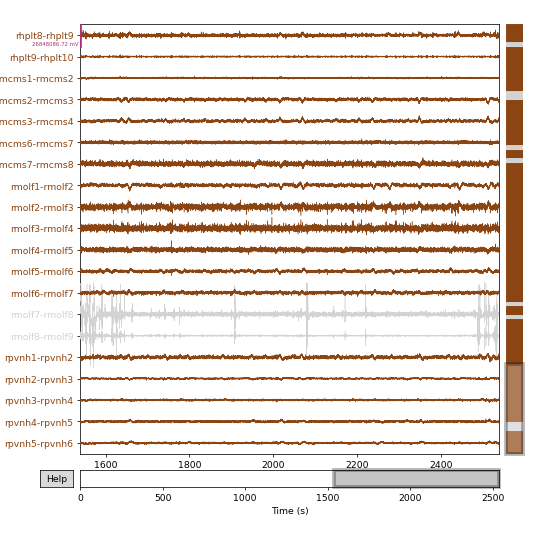

In [49]:
 %matplotlib notebook
fig = mne_data_bp_reref.plot(start=0, duration=1000, n_channels=20, scalings=mne_data_bp_reref._data.max()/5)


Effective window size : 0.512 (s)


<IPython.core.display.Javascript object>


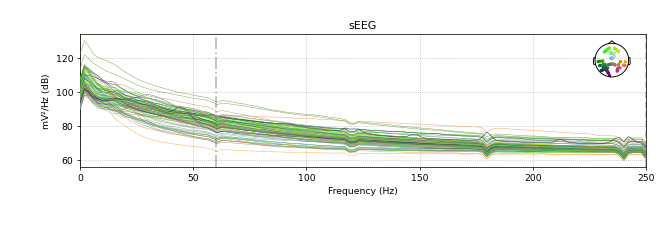

<IPython.core.display.Javascript object>


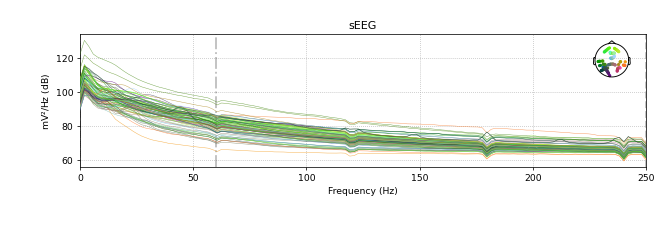

In [50]:
mne_data_bp_reref.compute_psd().plot()

In [51]:
print(mne_data_bp_reref.info['bads'],date)

['laglt1-laglt2', 'lcmip8-lcmip9', 'lcmip7-lcmip8', 'lmcms2-lmcms3', 'lmcms8-lmcms9', 'racas8-racas9', 'raglt7-raglt8', 'rmolf7-rmolf8', 'rmolf8-rmolf9'] 05212024


## Save Reref Data

In [52]:
mne_data_bp_reref.save(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS025/bp_ref_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS025/bp_ref_ieeg.fif
[done]


In [53]:
#remove mne_data from environment to save memory 
del mne_data, mne_data_bp_reref

# Photodiode Alignment
SWB photodiodes should be aligned to TrialOnset
- extract TrialOnset times to align to photodiode deflection onset 
- clean photodiode data if necessary (if photodiode is inverted, noisy etc)
- align photodiode (if function fails, try manual alignment)
- verify proper alignment by plotting

In [7]:
#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_task_data')
beh_ts = behav_df['TrialOnset'] #timestamp that should be aligned to photodiode 
behav_df

,Round,Trial Num,TrialType,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,RT,SafeBet,LowBet,...,totalCPE,decisionCPE,totalRegret,decisionRegret,totalRelief,decisionRelief,totalCF,decisionCF,pRPE,nRPE
0,1,17.0,mix,281.191734,281.194518,284.000014,286.015234,2.805496,0.0,-0.80,...,-1.12,-0.80,-1.12,-0.80,0.00,0.00,0.32,0.00,0.000,-0.56
1,2,132.0,loss,291.485670,291.494772,294.743755,296.760470,3.248982,-0.5,-0.91,...,0.91,0.50,0.00,0.00,0.91,0.50,-0.91,-0.50,0.455,0.00
2,3,141.0,loss,301.272516,301.288089,303.006460,303.013385,1.718371,-0.6,-1.01,...,0.41,0.41,0.00,0.00,0.41,0.41,-1.01,-1.01,0.000,0.00
3,4,56.0,gain,336.622560,336.630316,338.887292,338.895129,2.256976,0.2,0.00,...,0.20,0.20,0.00,0.00,0.20,0.20,0.00,0.00,0.000,0.00
4,5,73.0,gain,346.354041,346.354799,349.214847,351.231851,2.860048,0.4,0.00,...,-0.80,-0.40,-0.80,-0.40,0.00,0.00,0.80,0.40,0.000,-0.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,57.0,gain,2090.617402,2090.623172,2093.275802,2093.282839,2.652630,0.2,0.00,...,-0.43,-0.43,-0.43,-0.43,0.00,0.00,0.63,0.63,0.000,0.00
146,147,108.0,loss,2100.282703,2100.283575,2103.355231,2103.363451,3.071655,-0.2,-0.72,...,-0.20,-0.20,-0.20,-0.20,0.00,0.00,0.00,0.00,0.000,0.00
147,148,78.0,gain,2117.280533,2117.281256,2121.776867,2121.784627,4.495610,0.4,0.00,...,0.40,0.40,0.00,0.00,0.40,0.40,0.00,0.00,0.000,0.00
148,149,65.0,gain,2128.339101,2128.339835,2132.104251,2134.121392,3.764415,0.3,0.00,...,-0.74,-0.30,-0.74,-0.30,0.00,0.00,0.74,0.30,0.000,-0.37


In [8]:
#load photodiode data
photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS025/photodiode.fif...
Isotrak not found
    Range : 0 ... 1269503 =      0.000 ...  2539.006 secs
Ready.
Reading 0 ... 1269503  =      0.000 ...  2539.006 secs...


In [9]:
photodiode_data

<Raw | photodiode.fif, 1 x 1269504 (2539.0 s), ~9.7 MB, data loaded>

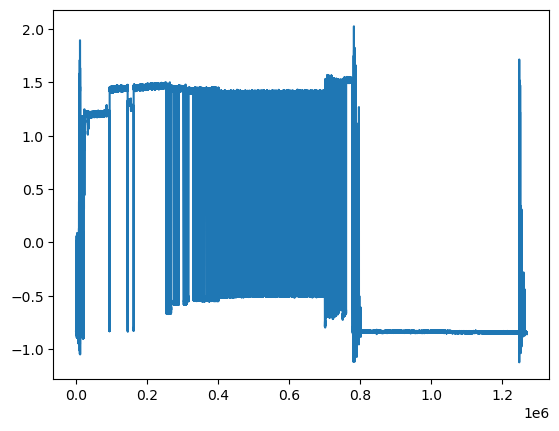

In [10]:
plt.plot(zscore(photodiode_data._data[0,:]))
plt.show()


In [11]:
temp_diode = photodiode_data.copy()
temp_diode._data = -temp_diode._data
temp_diode._data[0,775000:] = np.min(temp_diode._data[0,:])
temp_diode._data[0,:180000] = np.min(temp_diode._data[0,:])


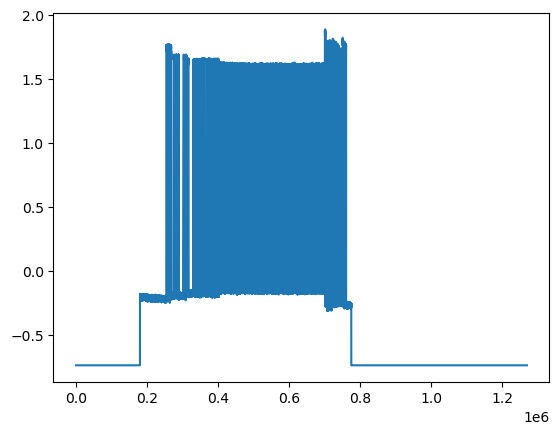

In [12]:
plt.plot(zscore(temp_diode._data[0,:]))
# plt.xlim([400000,500000])
plt.show()

In [13]:
### Photodiode alignment
smoothSize=11
windSize=15
height=0


# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            temp_diode, #
                                            smoothSize, windSize, height)

5 blocks
.....

found matches for 60 of 81 pulses


In [14]:
print(slope, offset,smoothSize,windSize,height)

0.9999972111513284 325.33864321027914 11 15 0


In [15]:
# calculate pulse times from slope + offset
pulses = [(x*slope + offset) for x in beh_ts]
len(pulses) 

150

In [16]:
##### validate by plotting!
photo_sfreq = photodiode_data.info['sfreq']
photo_sfreq


500.0

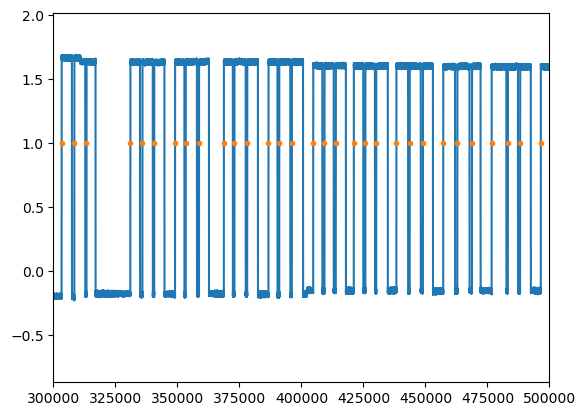

In [17]:
plt.plot(scipy.stats.zscore(temp_diode._data[0,:]))
plt.plot(np.array(pulses)*photo_sfreq, 
         np.ones_like(np.array(pulses)*photo_sfreq), '.')

plt.xlim([300000,500000])
plt.show()

In [18]:
photodiode_params = np.array([slope, offset])
diode_info_fname  = f'{neural_dir}diode_info/{subj_id}_diode_info'
np.save(diode_info_fname, photodiode_params)


# Epoch Data
- Epoch neural data into trial epochs (and save df with IEDs/artifacts for every ev)
- Save epochs
- Baseline + decompose data into TFRs
- Add behavioral data to epochs metadata
- Plot + save TFRs (examine quality)

Note: Check whether data is ready to be analyzed - if this step shows noise then steps above should be repeated


In [19]:
diode_info_fname  = f'{neural_dir}diode_info/{subj_id}_diode_info.npy'
photodiode_params = np.load(diode_info_fname)

photodiode_params

array([  0.99999721, 325.33864321])

In [ ]:
#to reload for more cleaning if necessary
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)

### Get behavior ts for epochs of interest
- time points in SWB code are nonsensical - choice onset is a repeat of trial onset, and the difference between choice onset and decision onset is just the RT.
- even worse, feedback onset does not accurately mark feedback for safe choice trials - the feedback time is the safe outcome reveal, NOT counterfactual feedback. There is no true counterfactual feedback timestamp that's accurate for every trial. 
- Solution - make a new timestamp vector that is +2 seconds after DecisionOnset to use for counterfactual outcome feedback epochs


MAJOR UPDATE 05/09/2024 FROM PIPELINE UPDATE

In [78]:
#### load behavior data and define baseline/analysis epoch timepoints 

#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
# behav_df = behav_df[behav_df['FeedbackOnset'] != 0] #remove fail trials from behav df
behav_df

,Round,Trial Num,TrialType,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,RT,SafeBet,LowBet,...,totalCPE,decisionCPE,totalRegret,decisionRegret,totalRelief,decisionRelief,totalCF,decisionCF,pRPE,nRPE
0,1,17.0,mix,281.191734,281.194518,284.000014,286.015234,2.805496,0.0,-0.80,...,-1.12,-0.80,-1.12,-0.80,0.00,0.00,0.32,0.00,0.000,-0.56
1,2,132.0,loss,291.485670,291.494772,294.743755,296.760470,3.248982,-0.5,-0.91,...,0.91,0.50,0.00,0.00,0.91,0.50,-0.91,-0.50,0.455,0.00
2,3,141.0,loss,301.272516,301.288089,303.006460,303.013385,1.718371,-0.6,-1.01,...,0.41,0.41,0.00,0.00,0.41,0.41,-1.01,-1.01,0.000,0.00
3,4,56.0,gain,336.622560,336.630316,338.887292,338.895129,2.256976,0.2,0.00,...,0.20,0.20,0.00,0.00,0.20,0.20,0.00,0.00,0.000,0.00
4,5,73.0,gain,346.354041,346.354799,349.214847,351.231851,2.860048,0.4,0.00,...,-0.80,-0.40,-0.80,-0.40,0.00,0.00,0.80,0.40,0.000,-0.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,57.0,gain,2090.617402,2090.623172,2093.275802,2093.282839,2.652630,0.2,0.00,...,-0.43,-0.43,-0.43,-0.43,0.00,0.00,0.63,0.63,0.000,0.00
146,147,108.0,loss,2100.282703,2100.283575,2103.355231,2103.363451,3.071655,-0.2,-0.72,...,-0.20,-0.20,-0.20,-0.20,0.00,0.00,0.00,0.00,0.000,0.00
147,148,78.0,gain,2117.280533,2117.281256,2121.776867,2121.784627,4.495610,0.4,0.00,...,0.40,0.40,0.00,0.00,0.40,0.40,0.00,0.00,0.000,0.00
148,149,65.0,gain,2128.339101,2128.339835,2132.104251,2134.121392,3.764415,0.3,0.00,...,-0.74,-0.30,-0.74,-0.30,0.00,0.00,0.74,0.30,0.000,-0.37


In [79]:
list(zip(behav_df.GambleChoice,behav_df.DecisionOnset,behav_df.FeedbackOnset))

[('gamble', 284.00001439999323, 286.0152343999944),
 ('gamble', 294.74375470000086, 296.7604696999915),
 ('safe', 303.0064602999919, 303.01338530000066),
 ('safe', 338.88729220000096, 338.8951289999968),
 ('gamble', 349.2148471999972, 351.2318510999903),
 ('safe', 358.5769550999976, 358.583870699993),
 ('gamble', 374.7019574000005, 376.7179778999998),
 ('gamble', 384.7967034999892, 386.8134354999929),
 ('safe', 394.4747567000013, 394.4817163999978),
 ('gamble', 414.24762379999447, 416.2638488999946),
 ('safe', 424.1092196999962, 424.11700119999296),
 ('safe', 433.987286699994, 433.9921885999938),
 ('gamble', 449.76165699999547, 451.777494199996),
 ('safe', 460.0895695999934, 460.0972666000016),
 ('safe', 470.3673662999936, 470.374433399993),
 ('safe', 485.9263550999895, 485.9333000999905),
 ('safe', 495.0881776000024, 495.09511389999534),
 ('gamble', 504.93245439999737, 506.94933999999193),
 ('safe', 518.958905099993, 518.9658651999925),
 ('gamble', 528.3548019000009, 530.3698235999909

In [80]:
behav_df['CpeOnset'] = behav_df.DecisionOnset + 2.0
behav_df['CpeOnset']

0       286.000014
1       296.743755
2       305.006460
3       340.887292
4       351.214847
          ...     
145    2095.275802
146    2105.355231
147    2123.776867
148    2134.104251
149    2143.099971
Name: CpeOnset, Length: 150, dtype: float64

## SWB Epochs:

**Baseline epoch** = 1 sec prior to trial onset \
**Decision epoch** = 0.5 sec prior to decision onset (choice epoch) \
**Feedback epoch** = 3 sec after CPE reveal \

*Outputs: Raw epoched data & IED + artifact dfs for every epoch*


In [81]:
# Define epochs of interest according to timestamps from behavior df 

# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [-0.5, 0], # 0.5 sec prior to choice
       'CpeOnset': [0,3.0] } # 3 sec following CPE outcome reveal - timestamps are made manually above

In [82]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

In [83]:
epochs_all_evs = {f'{x}': np.nan for x in evs}

In [84]:
### make epochs should now find IEDs, artifact times, and save info as df in load_path directory for every ev

for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/bp_ref_ieeg.fif', 
                                                 slope=slope, offset=offset,
                                                 behav_name=event, behav_times=behav_df[event].values,
                                                 ev_start_s=evs[event][0], ev_end_s=evs[event][1],
                                                 buf_s = 1, IED_args=IED_args,
                                                 downsamp_factor=None,  
                                                 detrend=0) #### new - constant detrend by DC offset https://mne.tools/stable/generated/mne.Epochs.html

    epochs_all_evs[event] = ev_epochs
    

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS025/bp_ref_ieeg.fif...
    Range : 0 ... 1269503 =      0.000 ...  2539.006 secs
Ready.
Reading 0 ... 1269503  =      0.000 ...  2539.006 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 sec)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:   13.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:   14.6s finished


Used Annotations descriptions: ['TrialOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 1501 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS025/bp_ref_ieeg.fif...
    Range : 0 ... 1269503 =      0.000 ...  2539.006 secs
Ready.
Reading 0 ... 1269503  =      0.000 ...  2539.006 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:   10.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:   14.5s finished


Used Annotations descriptions: ['DecisionOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 1251 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS025/bp_ref_ieeg.fif...
    Range : 0 ... 1269503 =      0.000 ...  2539.006 secs
Ready.
Reading 0 ... 1269503  =      0.000 ...  2539.006 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:   10.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:   15.3s finished


Used Annotations descriptions: ['CpeOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 2501 original time points ...
0 bad epochs dropped


In [85]:
epochs_all_evs 


{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~165.1 MB, data loaded,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1.5 - 1 sec, baseline off, ~137.6 MB, data loaded,
  'DecisionOnset': 150>,
 'CpeOnset': <Epochs |  150 events (all good), -1 - 4 sec, baseline off, ~274.9 MB, data loaded,
  'CpeOnset': 150>}

In [86]:
# to plot epochs if desired 
# %matplotlib notebook
# fig = epochs_all_subjs_all_evs['MS007']['feedback_start'].plot(n_epochs=10, n_channels=10)

# # Need this following line to save the annotations to the epochs object 
# fig.fake_keypress('a')

### Add behavioral data to metadata

In [87]:
behav_params = ['Round','RT','CpeOnset','GambleChoice','TrialType',
                'SafeBet', 'LowBet', 'HighBet', 'GambleEV','Outcome',
                'Profit', 'TotalProfit', 'CR', 'choiceEV', 'RPE',
                'decisionCPE', 'decisionRegret','decisionRelief', 'decisionCF']

In [88]:
for event in evs.keys():

    event_metadata = pd.DataFrame(columns=behav_params)
    
    #independent vars
    for param in behav_params: 
        event_metadata[param] = behav_df[param].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

Adding metadata with 19 columns
Adding metadata with 19 columns
Adding metadata with 19 columns


### Save raw epoched data 

In [89]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/{event}_epochs.fif', overwrite=True)

Overwriting existing file.
Overwriting existing file.
Overwriting existing file.


In [90]:
epochs_all_evs

{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~165.1 MB, data loaded, with metadata,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1.5 - 1 sec, baseline off, ~137.6 MB, data loaded, with metadata,
  'DecisionOnset': 150>,
 'CpeOnset': <Epochs |  150 events (all good), -1 - 4 sec, baseline off, ~274.9 MB, data loaded, with metadata,
  'CpeOnset': 150>}

# Compute Baseline + Analysis TFRs
*Major updates 05/09/2024*
- Instead of removing entire epochs with IEDs, removing +/-100ms of IED or artifact timepoint 
- Now we have two analysis evs of interest - pre-decision epoch and cpe outcome epoch

In [91]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict

baseline_ev  = 'TrialOnset' # fixation cross baseline epoch
analysis_evs = ['DecisionOnset','CpeOnset']

# dictionary of event ids and times - repeated from above
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [-0.5, 0], # 0.5 sec prior to choice
       'CpeOnset': [0,3.0] } # 3 sec following CPE outcome reveal - timestamps are made manually above

In [92]:
# Define spectrogram parameters for morlet wavelets 

freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = np.floor(np.logspace(*np.log10([3, 10]), num=30))


### Make Baseline TFR Epochs 

In [93]:
#### COMPUTE BASELINE TFRs 

# baseline epoch dictionary 
epochs_all_baseline = {} 

# baseline event = TrialOnset epochs 
baseline_epochs_reref = epochs_all_evs[baseline_ev]

# dropping bad channels from baseline epochs 
baseline_epochs_reref = baseline_epochs_reref.drop_channels(baseline_epochs_reref.info['bads'])

# compute baseline tfr 
temp_pow  = mne.time_frequency.tfr_morlet(baseline_epochs_reref, freqs=freqs, n_cycles=n_cycles, 
                                          picks=baseline_epochs_reref.ch_names, # now doesn't include bad ch
                                          use_fft=True, n_jobs=-1, output='power',
                                          return_itc=False, average=False) # returns pow (not ITC) for all epochs

temp_pow.crop(tmin=evs[baseline_ev][0], tmax=evs[baseline_ev][1]) # clipping epoch to remove buffer

# Remove bad data by naning out +/-100ms around bad timepoints (IEDs and artifacts)
# THE following will now LOAD in dataframes that indicate IED and artifact time points in your data
IED_df = pd.read_csv(f'{neural_dir}{subj_id}/{baseline_ev}_IED_df.csv') 
artifact_df = pd.read_csv(f'{neural_dir}{subj_id}/{baseline_ev}_artifact_df.csv') 

# iterate through each channel, IED/artifact & nan tfr data +/-100ms from IED/artifact
for ch_ix, ch_name in enumerate(baseline_epochs_reref.ch_names):
    # lists of IED/artifact timestamps from dfs for one channel (if any)
    ied_ev_list = IED_df[ch_name].dropna().index.tolist()
    artifact_ev_list = artifact_df[ch_name].dropna().index.tolist()
    
    # iterate through every IED timestamp in channel 
    for ev_ in ied_ev_list: 
        # iterate through values in IED df (literal eval = evaluates string as literal python data structures)
        for ied_ in literal_eval(IED_df[ch_name].iloc[ev_]):
            # remove 100 ms before 
            ev_ix_start = np.max([0, np.floor((ied_- 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            # remove 100 ms after 
            ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((ied_ + 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan
    
    # iterate through every artifact timestamp in channel 
    for ev_ in artifact_ev_list: 
         # iterate through values in artifact df (literal eval = evaluates string as literal python data structures)
        for artifact_ in literal_eval(artifact_df[ch_name].iloc[ev_]):
            # remove 100 ms before 
            ev_ix_start = np.max([0, np.floor((artifact_- 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            # remove 100 ms after
            ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((artifact_ + 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan

epochs_all_baseline[baseline_ev] = temp_pow


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:   41.1s finished


Adding metadata with 19 columns


In [94]:
epochs_all_baseline

{'TrialOnset': <EpochsTFR | time : [-1.000000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 87, ~1.46 GB>}

### Compute Baseline-corrected TFRs for Analysis Epochs

In [95]:
#### COMPUTE ANALYSIS EVENT TFRs + BASELINE TO BASELINE TFRs 

# repeat baselining procedure for every event in analysis_evs
# remove +/-100ms around IED/artifact individually for each analysis epoch 
# baseline analysis ev tfrs
# iteratively check for zscores still above 10 std, remove those timepoints, then recompute baselined tfr


power_epochs = {} # keys = analysis evs 

for event in analysis_evs: 
    print('Compute baselined TFR for epoch: ',event)
    
    # extract raw epoch data for analysis ev 
    event_epochs_reref = epochs_all_evs[event].copy()
    # dropping bad channels from baseline epochs 
    event_epochs_reref = event_epochs_reref.drop_channels(event_epochs_reref.info['bads'])
    ch_names = event_epochs_reref.ch_names
    
    # compute TFR from raw epoched data
    temp_pow = mne.time_frequency.tfr_morlet(event_epochs_reref, freqs=freqs, n_cycles=n_cycles, 
                                             picks=event_epochs_reref.ch_names, 
                                             use_fft=True, n_jobs=-1, output='power', 
                                             return_itc=False, average=False)
    # crop 1.0 sec buffer from analysis epoch 
    temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])
    
    ### repeat IED/artifact removal procedure used for baseline epochs, but with analysis event IED/artifact times
    
    # load IED/artifact dfs specific to event in analysis evs
    IED_df = pd.read_csv(f'{neural_dir}{subj_id}/{event}_IED_df.csv') 
    artifact_df = pd.read_csv(f'{neural_dir}{subj_id}/{event}_artifact_df.csv') 
    
    # iterate through each channel, IED/artifact & nan tfr data +/-100ms from IED/artifact
    for ch_ix, ch_name in enumerate(event_epochs_reref.ch_names): 
        ied_ev_list = IED_df[ch_name].dropna().index.tolist()
        artifact_ev_list = artifact_df[ch_name].dropna().index.tolist() 
        for ev_ in ied_ev_list: 
            for ied_ in literal_eval(IED_df[ch_name].iloc[ev_]):
                # remove 100 ms before 
                ev_ix_start = np.max([0, np.floor((ied_- 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                # remove 100 ms after
                ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((ied_ + 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan
        for ev_ in artifact_ev_list: 
            for artifact_ in literal_eval(artifact_df[ch_name].iloc[ev_]):
                # remove 100 ms before 
                ev_ix_start = np.max([0, np.floor((artifact_- 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                # remove 100 ms after
                ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((artifact_ + 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan

    ##### remove extreme power values (z>10) remaining after IED/artifact removal 
    # iterative process - baseline correct event TFR, remove z > 10, re-baseline until no z>10 or reached max iters
    
                
    # Let's nan out absurd z-scores (10 std above baseline???) that escaped our artifact detection, noise removal, and baselining
    absurdity_threshold = 10 # zscore threshold for removal
    max_iter = 10 # max number of iterations for while loop 
    large_z_flag=True # flag that indicates whether large zs are present, when all z<10 = False in while loop

    iteration = 0 # intialize iter counter
    while (large_z_flag==True) & (iteration<max_iter): # while z>10 still in tfr or under max iter num 
        print(f'baseline z-score iteration # {iteration}')
        # Baseline by all the baseline periods in the session
        baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
                              baseline_mne=epochs_all_baseline[baseline_ev].data,  
                              mode='zscore', ev_axis=0, elec_axis=1, freq_axis=2, time_axis=3)

        large_z_mask = np.where(baseline_corrected_power>absurdity_threshold)
        if large_z_mask[0].shape[0] == 0:
            # no more large z
            large_z_flag = False
        else:
            # NaN it out in the event of interest prior to re-running the baseline z-score to prevent
            # contamination of all z's
            temp_pow.data[large_z_mask] = np.nan

        iteration +=1
    
    # input baseline corrected pow into mne EpochsTFR object once all z>10 removed or iteratively removed 10x 
    zpow = mne.time_frequency.EpochsTFR(event_epochs_reref.info, baseline_corrected_power,
                                        temp_pow.times, freqs)
    
    # add metadata to baseline corrected TFR event epochs object 
    zpow.metadata = event_epochs_reref.metadata
    
    # save data (#conda install -c conda-forge h5io must install to save tfr data)
    zpow.save(f'{neural_dir}{subj_id}/{subj_id}_{event}-tfr.h5', overwrite=True) 
    
    # store event zpow epochs in dict for all analysis evs 
    power_epochs[event] = zpow
    

Compute baselined TFR for epoch:  DecisionOnset


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:   40.3s finished


Adding metadata with 19 columns
baseline z-score iteration # 0
baseline z-score iteration # 1
baseline z-score iteration # 2
baseline z-score iteration # 3
baseline z-score iteration # 4
baseline z-score iteration # 5
baseline z-score iteration # 6
baseline z-score iteration # 7
Not setting metadata
Adding metadata with 19 columns
Compute baselined TFR for epoch:  CpeOnset


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:   56.8s finished


Adding metadata with 19 columns
baseline z-score iteration # 0
baseline z-score iteration # 1
baseline z-score iteration # 2
baseline z-score iteration # 3
baseline z-score iteration # 4
baseline z-score iteration # 5
baseline z-score iteration # 6
baseline z-score iteration # 7
baseline z-score iteration # 8
baseline z-score iteration # 9
Not setting metadata
Adding metadata with 19 columns


In [96]:
power_epochs

{'DecisionOnset': <EpochsTFR | time : [-0.500000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 87, ~749.9 MB>,
 'CpeOnset': <EpochsTFR | time : [0.000000, 3.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 87, ~4.38 GB>}

In [97]:
power_epochs['DecisionOnset']

<EpochsTFR | time : [-0.500000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 87, ~749.9 MB>

In [98]:
power_epochs['CpeOnset']

<EpochsTFR | time : [0.000000, 3.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 87, ~4.38 GB>

# Plot TFRs 
- For each analysis event, plot the mean TFR across all epochs for all channels
- Save plots
- Visually inspect TFRs to see if further data cleaning is necessary

In [99]:
####add directory for TFRs
tfr_dir = f'{base_dir}ephys_analysis/figs/single_elec_tfrs/{subj_id}/'

# print date of TFR plotting 
date = datetime.date.today().strftime('%m%d%Y')
print(date, offset) # print date, double check current slope/offset


05212024 325.33864321027914


In [100]:
#### for each analysis event - plot one TFR averaged across all epochs for every electrode & save 

for event in analysis_evs: 
    print('Plot TFR for epoch: ',event)
    save_path = f'{tfr_dir}{event}/'
    os.makedirs(save_path,exist_ok = True) #added so you don't have to manually make folders
    
    ev_data = power_epochs[event].copy() # tfr plot data - epochs x num ch x freqs x times 
    times = ev_data.times.copy() # same for all elec
    
    for ch in ev_data.ch_names:
        # single ch tfr 
        plot_data = np.nanmean(np.nanmean(ev_data.copy().pick_channels([ch]).data, axis=0), axis=0) 
        
        fig, ax = plt.subplots(1, 1, figsize=(6, 4),dpi=300)
        
        im = ax.imshow(plot_data,interpolation='Bicubic',
                       aspect='auto', origin='lower', cmap='RdBu_r')
    

        ax.set(xlabel='Time (s)', ylabel='Frequency (Hz)',title=f'{subj_id}_{ch}_{event}_{date}',
               yticks=np.arange(0,len(freqs))[::5], 
               yticklabels=freqs[::5].astype(int), 
               xticks = np.arange(plot_data.shape[1])[::250],
                  xticklabels= times[::250])
        
        fig.colorbar(im, ax=ax)

        plt.savefig(f'{save_path}{subj_id}_{ch}_{event}_{date}.png', dpi=300)
#         bbox_inches=None, pad_inches=0.1,
#         facecolor='auto', edgecolor='auto',backend=None)
        plt.close()

    

Plot TFR for epoch:  DecisionOnset
Plot TFR for epoch:  CpeOnset
